# Probe combination

In this notebook we show how to perform <b>probe combination</b> in CosmoBolognaLib with 3 different methods:

1) <b>Importance sampling</b>: for each bin in the parameter-space we compute the ratio between the posterior distribution of the two probes. We have to evaluate the posterior distribution of one probe in the points of the other and viceversa, then we have to concatenate the resulting chains;

2) <b>log(Posterior) sum</b>: for every step chain we perform the summation of log(Posterior) distributions of the two input objects. This operation is embedded in the sampling posterior's function included in cbl::statistics::CombinedPosterior;

3) <b>A-posteriori importance sampling</b> for two chains (pre-runned).

The first two methods require datasets and models to run the chains while the last method read pre-runned chains, hence we are going to treat the last method independently from the other two.

At the and of the notebook we show the comparison between the first two methods and the comparison between the two importance sampling methods.

## Import modules

In [1]:
# to ensure compatibility in Python versions 2.x and 3.x
from __future__ import print_function

import CosmoBolognaLib as cbl

import numpy as np
import sys
import os

# import corner for contours plot
import corner

# import the wrapper that returns an object of type Model1D
from modelpy import getModel1D

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# to show the standard output stream of the CBL functions on notebook cells
%load_ext wurlitzer

## Set the I/O files & directories

In [2]:
dir_input = "/home/davide/ImpSamp/data/"
dir_output = "/home/davide/ImpSamp/chain/"
file_data1 = "data1.dat"
file_data2 = "data2.dat"

## Construct datasets & models

In [3]:
cosmology = cbl.Cosmology()

# construct the dataset by reading an input file
data1 = cbl.Data1D(dir_input+file_data1)
data2 = cbl.Data1D(dir_input+file_data2)

# construct the models
model1 = getModel1D(cosmology, 0)
model2 = getModel1D(cosmology, 1)

## Construct likelihoods & priors

In [4]:
# set the model parameter
valA, valB, valC = 1., 2., 1.

# limits for A and B
minA, maxA = -10., 10.
minB, maxB = -10., 10.

# define a Gaussian likelihood
likelihood1 = cbl.Likelihood(data1, model1, cbl.LikelihoodType__Gaussian_Error_)
likelihood2 = cbl.Likelihood(data2, model2, cbl.LikelihoodType__Gaussian_Error_)

# construct the priors
prior_A = cbl.PriorDistribution(cbl.DistributionType__Uniform_, minA, maxA)
prior_B = cbl.PriorDistribution(cbl.DistributionType__Uniform_, minB, maxB)
prior_C = cbl.PriorDistribution(cbl.DistributionType__Constant_, valC)
prior_distributions = cbl.PriorDistributionPtrVector([prior_A, prior_B, prior_C])

## Construct Posterior objects

In [5]:
# construct the posteriors
PostA = cbl.Posterior(prior_distributions, likelihood1, 696)
PostB = cbl.Posterior(prior_distributions, likelihood2, 696)

# put them into a pointer
ptr_posteriors = cbl.PosteriorPtrVector([PostA, PostB])

## Combine Posterior objects: 1) importance sampling

In this method we run the chain and, for each chain step, we evaluate the ratio between the two posterior distributions in a generic parameter-space point (importance weight). For two probes $A$ and $B$, we have to compute importance weight in both directions and then concatenate them. In the case of A reweighted with B::

$w_{A+B} = \frac{P_B(\vec{\theta_A})}{P_A(\vec{\theta_B})} = exp(\log P_B(\vec{\theta_A}) - \log P_A(\vec{\theta_A}) + \lambda_{SHIFT})$

where:

$\lambda_{SHIFT} = max(\log P_A(\vec{\theta_A})) - max(\log P_B(\vec{\theta_A}))$;

$\vec{\theta}$ are the parameters of the analysis.

### Combine

In [6]:
# construct the combination object by passing the pointer
CombPost = cbl.CombinedPosterior(ptr_posteriors)

# set parameters for posterior sampling
nwalkers = 10
chain_size = 5000
burn_in = 200
thin = 1

# set a starting point for the MCMC
start = [valA, valB]

# perform the importance sampling
CombPost.importance_sampling(dir_output, "model1", "model2", start, chain_size, nwalkers, burn_in, thin)

CBL > Maximizing the posterior...
CBL > Converged to a minimum at iteration 87 (<10000)
CBL > Done!

CBL > Parameter: A --> status: FREE
CBL > value =    1.00000
CBL > Parameter: B --> status: FREE
CBL > value =    4.20000
CBL > Parameter: C --> status: FIXED
CBL > value =    1.00000
CBL > Parameter: D --> status: OUTPUT
CBL > value =    6.20000
CBL > log(posterior) = 5.99

CBL > Sampling the posterior distribution for model1

CBL > Sampling the posterior...
CBL > Starting seed = 1578846948
CBL > Seed for random walker choice, first half = 11797701
CBL > Seed for random walker choice, second half = 1330525
CBL > Seed for Metropolis-Hastings algorithm = 20624828
CBL > Seed for random extraction from g(z) = 786506
CBL > 100% 37% 0;34mCBL > 57% 
CBL > Done!
CBL > I wrote the file: /home/davide/ImpSamp/chain/model1_chain.dat
CBL > I wrote the file: /home/davide/ImpSamp/chain/model1_parameters.dat
CBL > I wrote the file: /home/davide/ImpSamp/chain/model1_covariance.dat

CBL > Maximizing the

### Write & show results for importance sampling

In [9]:
# write results for importance sampling
CombPost.write_results(dir_output, "impsamp", burn_in, thin)

# show results for importance sampling
CombPost.show_results(burn_in, thin)

CBL > I wrote the file: /home/davide/ImpSamp/chain/impsamp_chain.dat
CBL > Parameter: A
CBL > Weighted Average: 1.21
CBL > Standard Deviation: 0.12

CBL > Parameter: B
CBL > Weighted Average: 2.87
CBL > Standard Deviation: 1.27

CBL > Parameter: C
CBL > Weighted Average: 1.00
CBL > Standard Deviation: 0.00

CBL > Parameter: D
CBL > Weighted Average: 5.08
CBL > Standard Deviation: 1.27



## Combine Posterior objects: 2) log(Posterior) sum

In this method we run the chain and, for each chain step, evaluate the resulting log(Posterior) as the sum of the log(Posterior) of the objects given in input:

$log(P_{fin}(\vec{\theta})) = \sum_{i=1}^{N} log(P_i(\vec{\theta}))$

In terms of likelihoods $\mathcal{L}$ and priors $\mathcal{P}$:

$log(P_{fin}(\vec{\theta}) = \sum_{i=1}^{N} log(\mathcal{L}_i(\vec{\theta})) + \sum_{i=1}^{N} log(\mathcal{P}_i(\vec{\theta}))$ where $N$ is the number of Posterior objecst given in input.

### Combine

In [11]:
# construct the combination object by passing the pointer
CombPost_sum = cbl.CombinedPosterior(ptr_posteriors)

# Initialize the chains
CombPost_sum.initialize_chains(chain_size, nwalkers, 1.e-5, start)

# Sampling the posterior
CombPost_sum.sample_stretch_move(2)

CBL > Maximizing the posterior...
CBL > Converged to a minimum at iteration 69 (<10000)
CBL > Done!

CBL > Parameter: A --> status: FREE
CBL > value =    1.17934
CBL > Parameter: B --> status: FREE
CBL > value =    2.86814
CBL > Parameter: C --> status: FIXED
CBL > value =    1.00000
CBL > Parameter: D --> status: OUTPUT
CBL > value =    5.04748
CBL > log(posterior) = 15.26

CBL > Sampling the posterior...
CBL > Starting seed = 1578846948
CBL > Seed for random walker choice, first half = 11797701
CBL > Seed for random walker choice, second half = 1330525
CBL > Seed for Metropolis-Hastings algorithm = 20624828
CBL > Seed for random extraction from g(z) = 786506
CBL > 100% 
CBL > Done!


### Write & show results for log(Posterior) sum

In [12]:
#write results for importance sampling
CombPost_sum.write_results(dir_output, "logpost_sum", burn_in, thin)

#show results for importance sampling
CombPost_sum.show_results(burn_in, thin)

CBL > I wrote the file: /home/davide/ImpSamp/chain/logpost_sum_chain.dat
CBL > I wrote the file: /home/davide/ImpSamp/chain/logpost_sum_parameters.dat
CBL > I wrote the file: /home/davide/ImpSamp/chain/logpost_sum_covariance.dat

CBL > Parameter: A --> status: FREE
CBL > Posterior mean =    1.18053
CBL > Posterior standard deviation =    0.03470
CBL > Posterior median =    1.18141
CBL > Posterior 18th percentile =    0.03272
CBL > Posterior 82th percentile =    0.03082

CBL > Parameter: B --> status: FREE
CBL > Posterior mean =    2.85832
CBL > Posterior standard deviation =    0.21816
CBL > Posterior median =    2.85580
CBL > Posterior 18th percentile =    0.19819
CBL > Posterior 82th percentile =    0.20296

CBL > Parameter: C --> status: FIXED
CBL > value =   1.00000
CBL > Parameter: D --> status: OUTPUT
CBL > Posterior mean =    5.03894
CBL > Posterior standard deviation =    0.20074
CBL > Posterior median =    5.03699
CBL > Posterior 18th percentile =    0.18207
CBL > Posterior 82

## Combine Posterior objects: 3) A-posteriori importance sampling

In this case we read two external chains file (pre-runned) and perform importance sampling between the log(Posterior) distributions. In order to do this we need the log(Posterior) of one MCMC in the points of the
other and viceversa, so we interpolate it using the function interpolate of cbl::ChainMesh, which is called by importance_sampling function of cbl::statistics::CombinedPosterior. The importance weights are computed as the previous importance sampling method.

### Construct Posterior objects by reading from external files

In [14]:
#pre-runned chains names
file_A = "model1_chain.dat"
file_B = "model2_chain.dat"

# choose the columns that you want to read --> starting from 1, last one for the log(Posterior)
usecols = [2,3,5,8]

param_names = ['A', 'B', 'D']

skip_header = 1

PostA = cbl.Posterior(file_A, dir_output, usecols, param_names, skip_header)
PostB = cbl.Posterior(file_B, dir_output, usecols, param_names, skip_header)

# put them into a pointer
ptr_posteriors = cbl.PosteriorPtrVector([PostA, PostB])

### Combine

In [15]:
# construct the combination object by passing the pointer
CombPost_ext = cbl.CombinedPosterior(ptr_posteriors)

# define the parameter for the interpolation
distNum = 100
cell_size = 2.
rMAX = 2.

# the number of sigma that you want to cut in order to avoid spikes. cut_w = -1 --> no cut
cut_w = -1.

# perform the importance sampling
CombPost_ext.importance_sampling(distNum, cell_size, rMAX, cut_w)

### Write & show results for A-posteriori importance sampling

In [16]:
# write the resulting chain on a output file
CombPost_ext.write_results(dir_output, "ext_impsamp", 0, 1)

# show results on the screen
CombPost_ext.show_results(0, 1)

CBL > I wrote the file: /home/davide/ImpSamp/chain/ext_impsamp_chain.dat
CBL > Parameter: A
CBL > Weighted Average: 1.18
CBL > Standard Deviation: 0.12

CBL > Parameter: B
CBL > Weighted Average: 3.04
CBL > Standard Deviation: 1.27

CBL > Parameter: D
CBL > Weighted Average: 5.22
CBL > Standard Deviation: 1.27



## Define function that plots contours in parameter-space

In [17]:
def plot_contours(points, label_probe, weights, color, label_params, figure, axes):

    range = [(0.60, 1.38), (0.2,6.4), (1.8, 9)]

    corner.corner(points, weights=weights, \
           color=color, smooth=True, labels=label_params, range=range, \
           show_titles=True, bins=40, plot_datapoints=False, plot_contours=True, plot_density=True, \
           levels=[0.68, 0.95], fill_contours=True, max_n_ticks = 5, truth_color="k", alpha=0.8, \
           label_kwargs={"fontsize": 23}, title_kwargs={"fontsize": 20}, \
           hist_kwargs={"density" : True, "color":color}, fig=figure)

    axes[0][1].plot(1,1, color, label=label_probe)
    axes[0][1].legend(loc="center left", fontsize=15)

## Extract data and plot contours: compare log(Posterior) sum with importance sampling

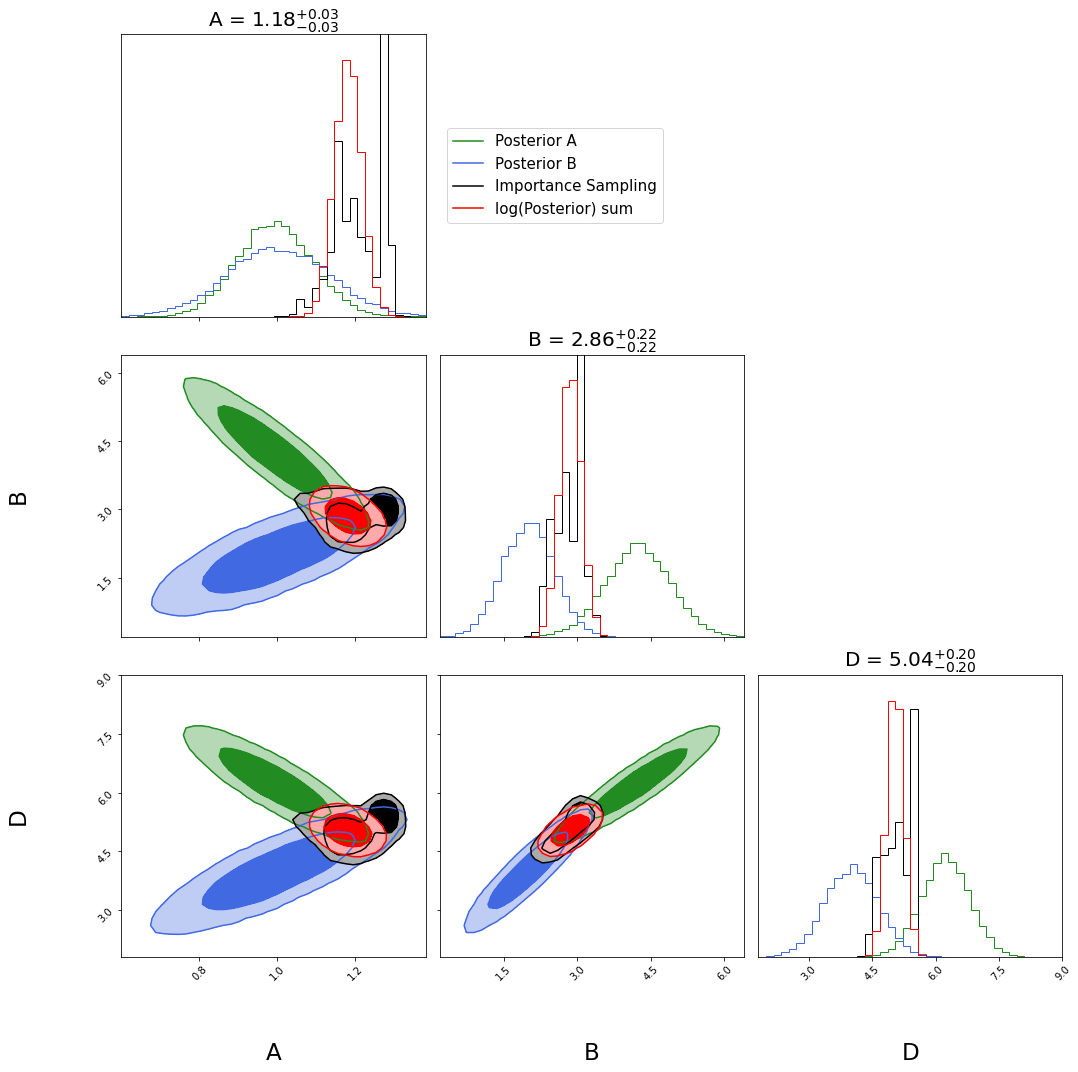

In [18]:
file_IS = "impsamp_chain.dat"
file_sum = "logpost_sum_chain.dat"
file_ext = "ext_impsamp_chain.dat"

A_1, B_1, D_1 = np.genfromtxt(dir_output+file_A, usecols=(1, 2, 4), unpack=True)
A_2, B_2, D_2 = np.genfromtxt(dir_output+file_B, usecols=(1, 2, 4), unpack=True)
A_IS, B_IS, D_IS, weights = np.genfromtxt(dir_output+file_IS, usecols=(1, 2, 4, 6), unpack=True)
A_sum, B_sum, D_sum = np.genfromtxt(dir_output+file_sum, usecols=(1,2,4), unpack=True)
A_ext, B_ext, D_ext, w_ext = np.genfromtxt(dir_output+file_ext, usecols=(1, 2, 3, 5), unpack=True)

points_A = list(zip(A_1, B_1, D_1))
points_B = list(zip(A_2, B_2, D_2))
points_IS = list(zip(A_IS, B_IS, D_IS))
points_sum = list(zip(A_sum, B_sum, D_sum))
points_ext = list(zip(A_ext, B_ext, D_ext))

col_1 = "forestgreen"
col_2 = "royalblue"
col_IS = "k"
col_sum = "red"
col_ext = "red"

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

plot_contours(points_A, "Posterior A", None, col_1, param_names, fig, axes)
plot_contours(points_B, "Posterior B", None, col_2, param_names, fig, axes)
plot_contours(points_IS, "Importance Sampling", weights, col_IS, param_names, fig, axes)
plot_contours(points_sum, "log(Posterior) sum", None, col_sum, param_names, fig, axes)

plt.tight_layout()

## Compare importance sampling methods

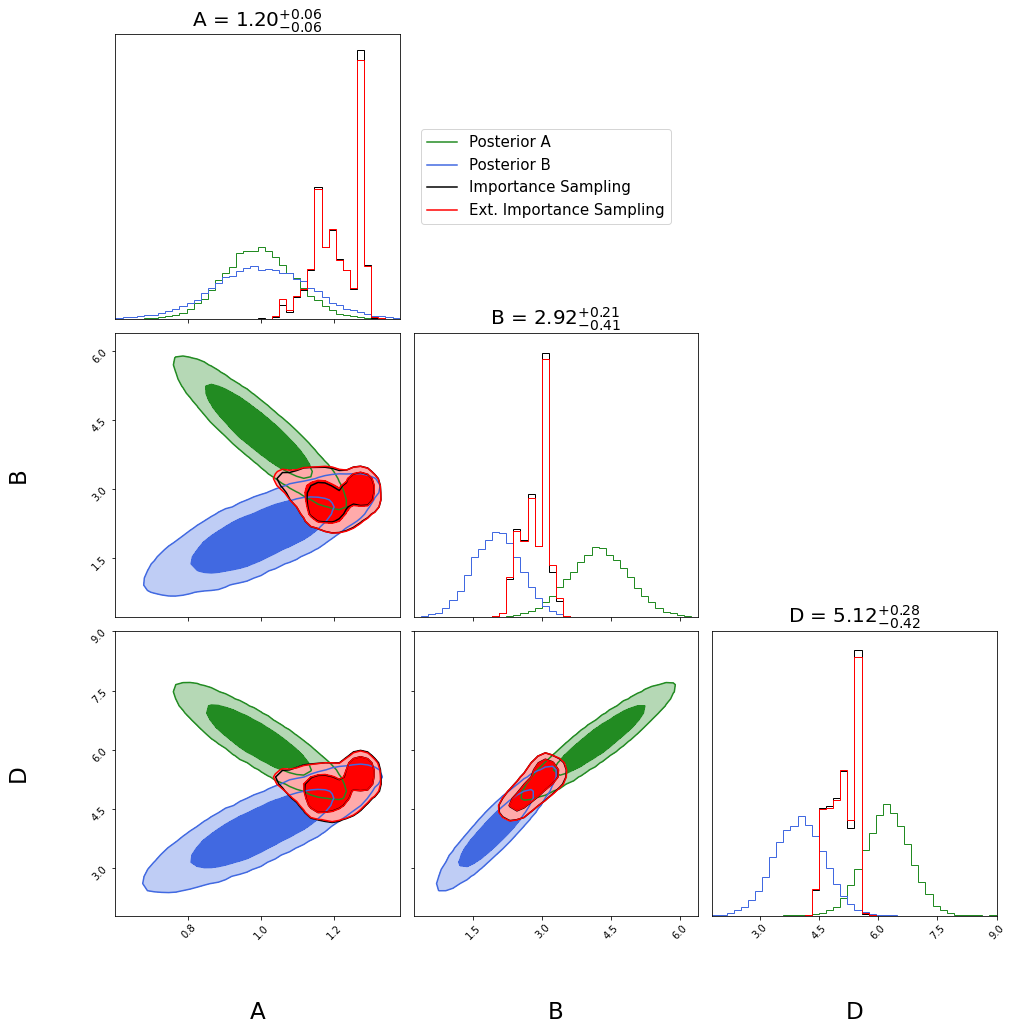

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

plot_contours(points_A, "Posterior A", None, col_1, param_names, fig, axes)
plot_contours(points_B, "Posterior B", None, col_2, param_names, fig, axes)
plot_contours(points_IS, "Importance Sampling", weights, col_IS, param_names, fig, axes)
plot_contours(points_ext, "Ext. Importance Sampling", w_ext, col_ext, param_names, fig, axes)